<a href="https://www.kaggle.com/code/itsamer/titanium-titanic-explained?scriptVersionId=109891420" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**P.S. **I have created a simple model to predict the  survived passengers. I will follow this up with updates to improve this score as well as improving the data visualization.****

# **1.Arrangement**

# **1.1 Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix


# **1.2 Load Dataset**

In [2]:
#import Dataset
train  = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
test_ids = test["PassengerId"]


# **1.3 Checking Null Values**

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [4]:
pd.DataFrame(data = [train.isna().sum()/train.shape[0]*100, test.isna().sum()/test.shape[0]*100], index=["Train Null (%)", "Test Null (%)"]).T.style.background_gradient()

,Train Null (%),Test Null (%)
PassengerId,0.000000,0.000000
Survived,0.000000,nan
Pclass,0.000000,0.000000
Name,0.000000,0.000000
Sex,0.000000,0.000000
Age,19.865320,20.574163
SibSp,0.000000,0.000000
Parch,0.000000,0.000000
Ticket,0.000000,0.000000
Fare,0.000000,0.239234


we conclude that cabin is mising most of its values in both training and test sets, Emparked and Fare values however just have 2 & 1 respectivly mising values.

# **1.4 Checking Duplicate Data**

In [5]:
print(f"Train duplicated data: {train.duplicated().sum()} ")
print(f"Test duplicated data : {test.duplicated().sum()} ")

Train duplicated data: 0 
Test duplicated data : 0 


Great ! there is no duplicated values.

# **1.5 Checking Dataset Information**

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


To Understand the data more we should defrentiate the variables [types](https://www150.statcan.gc.ca/n1/edu/power-pouvoir/ch8/5214817-eng.htm)
* **Numerical  :**
    * ***Discrete*** :  - SibSp
                  - Parch
                   
    * ***Continous***:  - Age
                  - Fare
                  
* **Catogrical :**   
    * ***Nominal***  :  - Sex
                  - Embarked
                  - Survived  (target)
                  
    * ***Ordinal***  :  - Pclass
    
* **The rest as:**  
    * ***Text***     :  - Ticket
                 - Name
                        
    * ***Number***   :  - PassengerId

# **2. Exploratory Data Analysis**


> before starting lets group the Catogrical and Numircal. Creaet two function to visualize them

In [7]:
num_var = ["SibSp", "Parch", "Age", "Fare"]
cat_var = ["Sex", "Embarked", "Pclass"]
target = "Survived"
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data=data, x=var, kde=True, ax=ax[0])
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")

    plt.show()
    
def cat_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    mycolors = ["#E74C3C", "#F4D03F", "#2980B9", "#9B59B6"]

    train[var].value_counts().plot(kind="pie", explode=[0.05 for x in data[var].dropna().unique()],colors = mycolors, autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{var} Pie Chart")
    ax[0].set_ylabel('')

    count = sns.countplot(x=var, data=train, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{var} Bar Chart")
    plt.show()

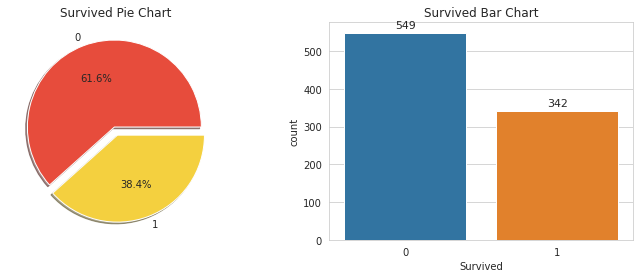

In [8]:
cat_dist(train, "Survived")

In [9]:
def clean(data):
    data = data.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)
    cols = ["SibSp","Parch","Fare","Age"]
    for col in cols:
        data[col].fillna(data[col].median(), inplace=True)
    data.Embarked.fillna("U", inplace=True)
    return data
train = clean(train)
test = clean(test)    

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cols = ["Sex","Embarked"]

for col in cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    print(le.classes_)
    
train.head()

['female' 'male']
['C' 'Q' 'S' 'U']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [11]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
y = train["Survived"]
X = train.drop("Survived", axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

In [13]:
predictions = clf.predict(X_val)
from sklearn.metrics import accuracy_score
accuracy_score(y_val, predictions)

0.8100558659217877

In [14]:
submission_preds = clf.predict(test)

In [15]:
df = pd.DataFrame({"PassengerId": test_ids.values,
                   "Survived": submission_preds,
                  })

In [16]:
df.to_csv("submission.csv", index=False)

In [17]:
result = pd.read_csv('./submission.csv').head()

In [18]:
pd.DataFrame()

""
